<a href="https://colab.research.google.com/github/AAA530/Higgs_boson_classification/blob/main/AI_project_higgs_boson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setting up the colab notebook

In [54]:
! pip install -q kaggle

In [55]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"aaa530","key":"810688b283394e65d41f44aa8e38f705"}'}

In [56]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [57]:
! chmod 600 ~/.kaggle/kaggle.json

In [58]:
! kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          34502        948  1.0              
tawfikelmetwally/automobile-dataset                                   Car information dataset                               6KB  2023-05-28 18:26:48           4678        135  0.9411765        
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           6740        144  1.0              
mohithsairamreddy/salary-data 

In [59]:
! kaggle competitions download -c higgs-boson

higgs-boson.zip: Skipping, found more recently modified local copy (use --force to force download)


In [60]:
! mkdir higgs-boson

mkdir: cannot create directory ‘higgs-boson’: File exists


In [61]:
!unzip higgs-boson.zip -d higgs-boson/

Archive:  higgs-boson.zip
replace higgs-boson/HiggsBosonCompetition_AMSMetric_rev1.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: higgs-boson/HiggsBosonCompetition_AMSMetric_rev1.py  
  inflating: higgs-boson/random_submission.zip  
  inflating: higgs-boson/test.zip    
  inflating: higgs-boson/training.zip  


In [62]:
! mkdir higgs-boson/train

mkdir: cannot create directory ‘higgs-boson/train’: File exists


In [63]:
!unzip higgs-boson/training.zip -d higgs-boson/train/

Archive:  higgs-boson/training.zip
replace higgs-boson/train/training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: higgs-boson/train/training.csv  


## Starting with data visualization and data preprocessing

### Project Objective
The objective of the project is to classify an event produced in the particle accelerator as background or signal. As described earlier, a background event is explained by the existing theories and previous observations. A signal event, however, indicates a process that cannot be described by previous observations and leads to the potential discovery of a new particle.

In [65]:
# File system manangement
import time, psutil, os

# Mathematical functions
import math

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data

import seaborn as sns
sns.set_theme()
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [66]:
# Loading the training data
data_train = pd.read_csv('higgs-boson/training.zip')
data_test = pd.read_csv('higgs-boson/test.zip')

print(pd.Series({"Memory usage": "{:.2f} MB".format(data_train.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_train.shape)}).to_string())
data_train.head()

Memory usage         62.94 MB
Dataset shape    (250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [67]:
data_train.loc[data_train.index[0]]

EventId                          100000
DER_mass_MMC                     138.47
DER_mass_transverse_met_lep      51.655
DER_mass_vis                     97.827
DER_pt_h                          27.98
DER_deltaeta_jet_jet               0.91
DER_mass_jet_jet                124.711
DER_prodeta_jet_jet               2.666
DER_deltar_tau_lep                3.064
DER_pt_tot                       41.928
DER_sum_pt                       197.76
DER_pt_ratio_lep_tau              1.582
DER_met_phi_centrality            1.396
DER_lep_eta_centrality              0.2
PRI_tau_pt                       32.638
PRI_tau_eta                       1.017
PRI_tau_phi                       0.381
PRI_lep_pt                       51.626
PRI_lep_eta                       2.273
PRI_lep_phi                      -2.414
PRI_met                          16.824
PRI_met_phi                      -0.277
PRI_met_sumet                   258.733
PRI_jet_num                           2
PRI_jet_leading_pt               67.435


In [68]:
data_test = pd.read_csv('higgs-boson/test.zip')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data_test.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_test.shape)}).to_string())
data_test.head()


Memory usage        130.08 MB
Dataset shape    (550000, 31)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,350000,-999.000,79.589,23.916,3.036,-999.000,-999.000,-999.000,0.903,3.036,...,2.022,98.556,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,-0.000
1,350001,106.398,67.490,87.949,49.994,-999.000,-999.000,-999.000,2.048,2.679,...,-1.138,176.251,1,47.575,-0.553,-0.849,-999.000,-999.000,-999.000,47.575
2,350002,117.794,56.226,96.358,4.137,-999.000,-999.000,-999.000,2.755,4.137,...,-1.868,111.505,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
3,350003,135.861,30.604,97.288,9.104,-999.000,-999.000,-999.000,2.811,9.104,...,1.172,164.707,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
4,350004,74.159,82.772,58.731,89.646,1.347,536.663,-0.339,1.028,77.213,...,-0.231,869.614,3,254.085,-1.013,-0.334,185.857,0.335,2.587,599.213


In [69]:
# Shape of the data
print(pd.Series({"Shape of the training set": data_train.shape,
                 "Shape of the test set": data_test.shape}).to_string())

Shape of the training set    (250000, 33)
Shape of the test set        (550000, 31)


In [70]:
# Count of observations
df_obs = pd.DataFrame(index = ['Number of observations'], columns = ['Training set', 'Test set'])
df_obs['Training set'] = len(data_train)
df_obs['Test set'] = len(data_test)
df_obs

,Training set,Test set
Number of observations,250000,550000


In [71]:
# Count of columns
df_cols_count = pd.DataFrame(index = ['Number of columns'], columns = ['Training set', 'Test set'])
df_cols_count['Training set'] = len(data_train.columns)
df_cols_count['Test set'] = len(data_test.columns)
df_cols_count

,Training set,Test set
Number of columns,33,31


In [72]:
# Column names for the training dataset
data_train.columns


Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt',
       'Weight', 'Label'],
      dtype='object')

In [73]:
# Column names for the test dataset
data_test.columns

Index(['EventId', 'DER_mass_MMC', 'DER_mass_transverse_met_lep',
       'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet',
       'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt',
       'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality',
       'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'],
      dtype='object')

In [74]:
# Count of column datatypes for the training dataset
df_cols_train = pd.DataFrame(index = ['Number of columns for the training set'], columns = ['Integer', 'Float', 'Object'])
df_cols_train['Integer'] = len(data_train.columns[data_train.dtypes == 'int64'])
df_cols_train['Float'] = len(data_train.columns[data_train.dtypes == 'float64'])
df_cols_train['Object'] = len(data_train.columns[data_train.dtypes == 'object'])
df_cols_train

,Integer,Float,Object
Number of columns for the training set,2,30,1


In [75]:
# Statistical description of numerical variables in the training set
data_train.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


In [76]:
# Statistical description of numerical variables in the test set
data_test.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,...,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000,550000.000000
mean,624999.500000,-48.950144,49.261093,81.123904,57.824801,-707.448878,-599.705905,-708.391425,2.374076,18.988277,...,-0.008214,209.933695,0.980171,-348.946684,-399.883839,-399.896234,-691.309277,-708.150605,-708.153058,73.248856
std,158771.468365,406.233686,35.425422,40.435560,63.291314,454.928791,659.129589,453.461222,0.779895,21.767376,...,1.812777,126.910079,0.979271,533.155176,489.467786,489.457747,480.435230,453.834190,453.830095,98.467134
min,350000.000000,-999.000000,0.000000,6.810000,0.000000,-999.000000,-999.000000,-999.000000,0.237000,0.000000,...,-3.142000,13.847000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000
25%,487499.750000,78.167750,19.313000,59.422000,14.192000,-999.000000,-999.000000,-999.000000,1.815000,2.838000,...,-1.574000,122.984750,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,624999.500000,105.076000,46.455500,73.747000,38.469500,-999.000000,-999.000000,-999.000000,2.492000,12.390000,...,-0.017000,179.949000,1.000000,38.970000,-1.862000,-2.111000,-999.000000,-999.000000,-999.000000,40.503500
75%,762499.250000,130.769000,73.646000,92.173000,79.234250,0.503000,84.266250,-4.538000,2.962000,27.649000,...,1.558000,263.917250,2.000000,75.499000,0.431000,0.484000,33.832000,-2.429000,-2.260000,110.507000
max,899999.000000,1949.261000,968.669000,1264.965000,1337.187000,8.724000,4794.827000,17.294000,5.751000,759.363000,...,3.142000,2190.275000,3.000000,1163.439000,4.500000,3.142000,817.801000,4.500000,3.142000,1860.175000


**Training set synopsis:**
*   Number of observations:  250000
*   Number of columns:  33
*   Number of integer columns:  2
*   Number of float columns:  30
*   Number of object columns:  1
*   Number of duplicate observations:  0
*   Constant columns: None
*   Number of columns with missing values:  0
*   Memory Usage:  62.94 MB



**Test set synopsis:**

*   Number of observations:  550000
*   Number of columns:  31
*   Number of integer columns:  2
*   Number of float columns:  29
*   Number of object columns:  0
*   Number of duplicate observations:  0
*   Constant columns: None
*   Number of columns with missing values:  0
*   Memory Usage:  130.08MB

### univarate Analysis

In [77]:
# Matplotlib patches for adding manual legends
grey_patch = mpatches.Patch(color = 'grey', label = "Train")
red_patch = mpatches.Patch(color = 'red', label = "Test")

# Function to construct barplot and donutplot of a dataframe column
def bar_donut(df, col, h = 500, w = 800):
    fig = make_subplots(rows = 1, cols = 2, specs = [[{'type': 'xy'}, {'type': 'domain'}]])
    x_val, y_val = df[col].value_counts(sort = False).index.tolist(), df[col].value_counts(sort = False).tolist()
    fig.add_trace(go.Bar(x = x_val, y = y_val, text = y_val, textposition = 'auto'), row = 1, col = 1)
    fig.add_trace(go.Pie(values = y_val, labels = x_val, hole = 0.5, textinfo = 'label+percent', title = f"{col}"), row = 1, col = 2)
    fig.update_layout(height = h, width = w, showlegend = False, xaxis = dict(tickmode = 'linear', tick0 = 0, dtick = 1), title = dict(text = f"Frequency distribution of {col}", x = 0.5, y = 0.95))
    fig.show()

In [78]:
# Target variable
bar_donut(data_train, 'Label')

In [79]:
# Splitting the training by target class
data_train_b = data_train[data_train['Label'] == 'b'] # Background events in the training set
data_train_s = data_train[data_train['Label'] == 's'] # System events in the training set

In [80]:
# Number of unique values for the predictor variables
df_unique = pd.DataFrame()
df_unique['Training set (background events)'] = [data_train_b[col].nunique() for col in data_test.columns]
df_unique['Training set (signal events)'] = [data_train_s[col].nunique() for col in data_test.columns]
df_unique['Training set (all events)'] = [data_train[col].nunique() for col in data_test.columns]
df_unique['Test set (all events)'] = [data_test[col].nunique() for col in data_test.columns]
df_unique.set_index(data_test.columns, inplace = True)
df_unique.style.set_caption("Number of unique values for the predictor variables")

,Training set (background events),Training set (signal events),Training set (all events),Test set (all events)
EventId,164333,85667,250000,550000
DER_mass_MMC,85521,51645,108338,152743
DER_mass_transverse_met_lep,87812,50941,101637,123271
DER_mass_vis,88377,48615,100558,134982
DER_pt_h,84305,64625,115563,165204
DER_deltaeta_jet_jet,5624,6989,7087,7487
DER_mass_jet_jet,38310,31880,68366,140826
DER_prodeta_jet_jet,11605,13627,16593,20258
DER_deltar_tau_lep,4688,3399,4692,4900
DER_pt_tot,50605,36604,59042,76134


Comparison of feature distributions for the training set and the test set
First we check the distributions of the features for the training set and the test set. If we are to train our model on one set (the training set) and use it to make predictions on another (the test set), then it is desirable that the distributions corresponding to the two sets have similar structure.

In [81]:
# Combining the data
data_train_temp = data_train.copy(deep = True)
data_train_temp['dataset'] = "Train"
data_test_temp = data_test.copy(deep = True)
data_test_temp['dataset'] = "Test"
data = pd.concat([data_train_temp, data_test_temp], axis = 0, ignore_index = True)

In [82]:
# Function to plot distributions of the float features
def hist(df, cols, bins, ncols = 3):
    nrows = math.ceil(len(cols) / ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize = (5 * ncols, 4.2 * nrows), sharey = False)
    for i in range(len(cols)):
        sns.histplot(data = df, x = cols[i], bins = bins, hue = 'dataset', palette = ['red', 'grey'], ax = ax[i // ncols, i % ncols])
        ax[i // ncols, i % ncols].set_xlabel(cols[i])
        if i % ncols != 0:
            ax[i // ncols, i % ncols].set_ylabel(" ")
    plt.tight_layout()
    plt.show()

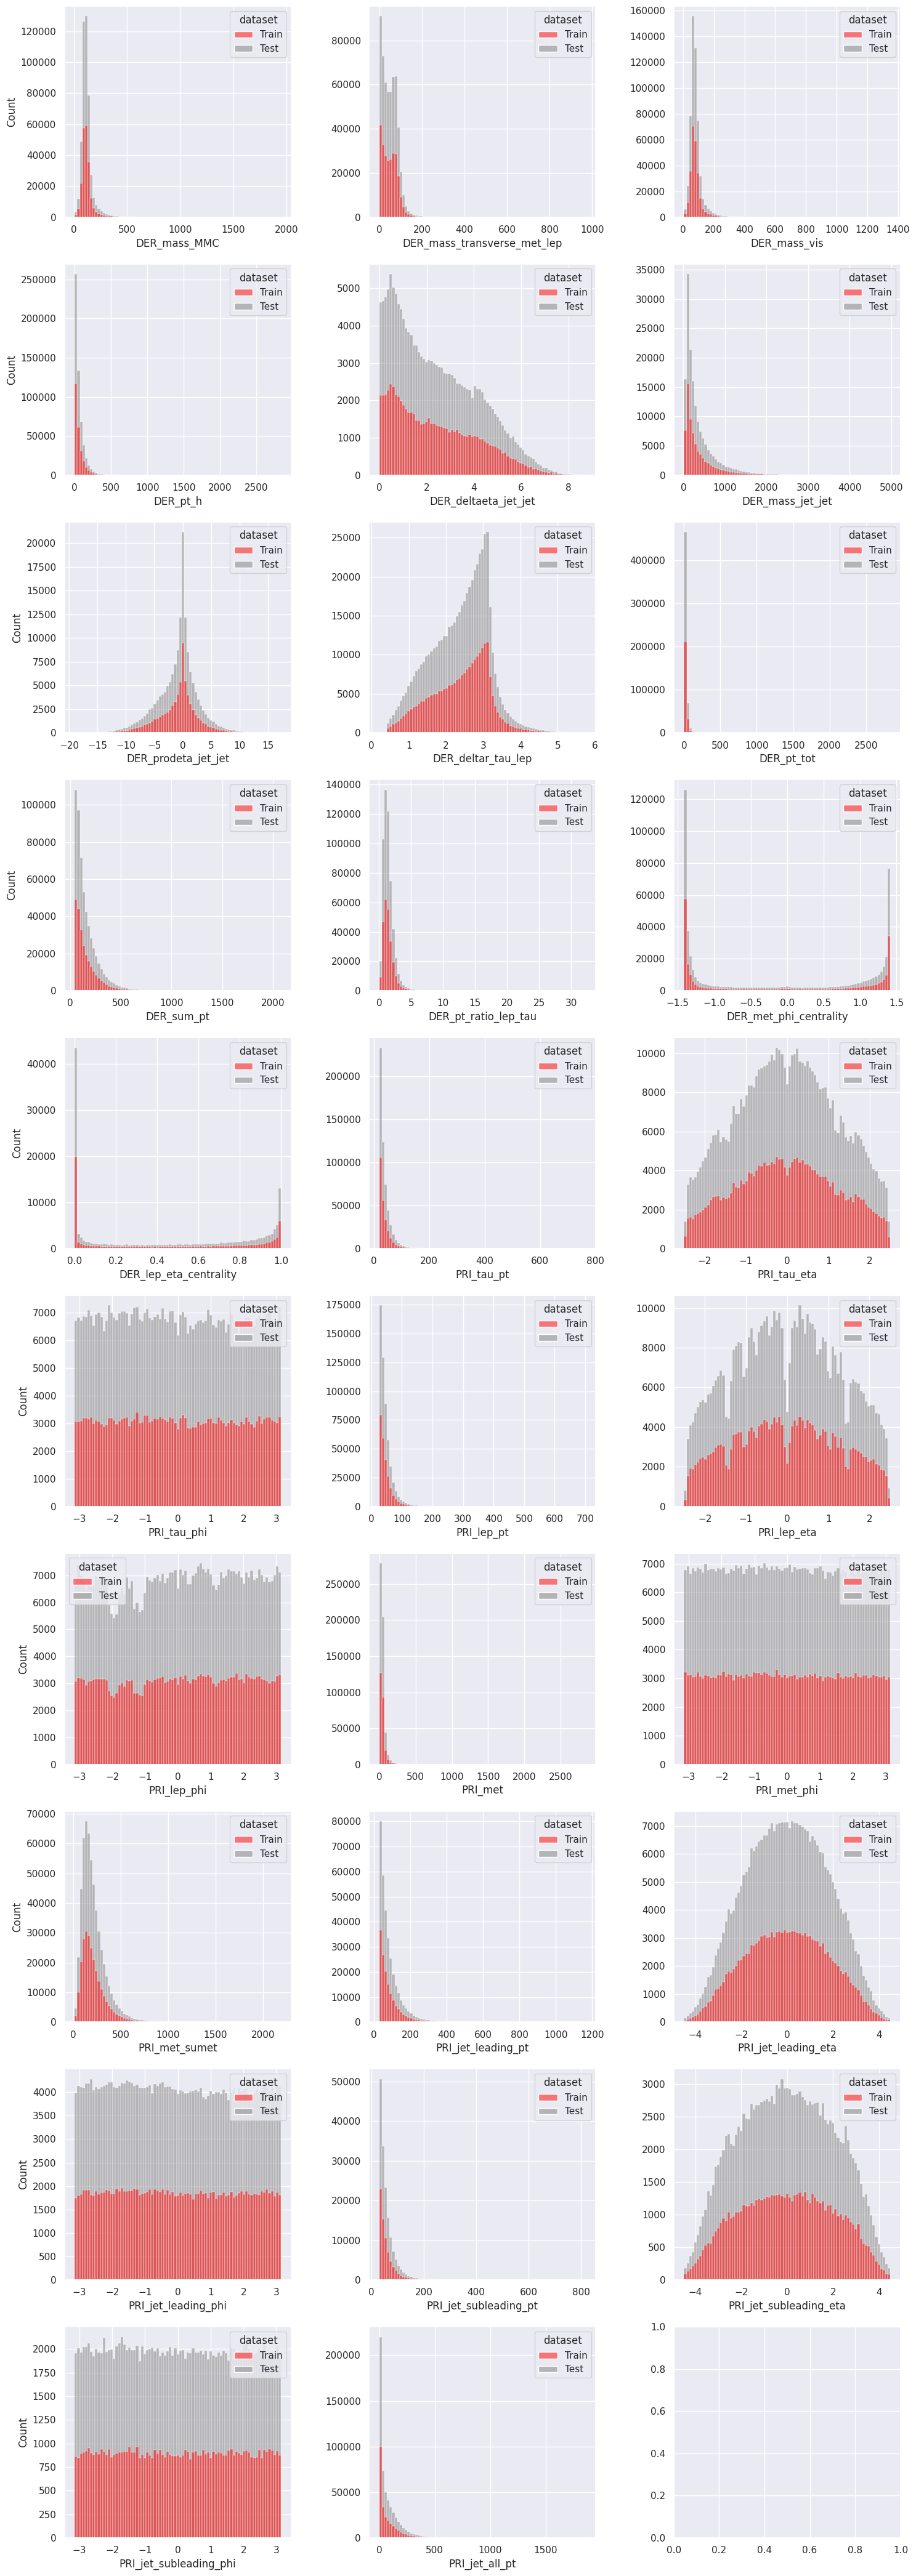

In [83]:
# Distributions of the float features
hist(data.replace(-999, np.nan),
     list(data_test.columns[data_test.dtypes == 'float64']),
     bins = max(math.floor(len(data_train)**(1/3)), math.floor(len(data_test)**(1/3))),
     ncols = 3)

In [84]:
# Skewness of the float features
df_skew = pd.DataFrame()
cols_float_test = data_test.columns[data_test.dtypes == 'float64']
skew_train_b = data_train_b.replace(-999, np.nan)[cols_float_test].skew().values
skew_train_s = data_train_s.replace(-999, np.nan)[cols_float_test].skew().values
skew_train = data_train.replace(-999, np.nan)[cols_float_test].skew().values
skew_test = data_test.replace(-999, np.nan)[cols_float_test].skew().values
df_skew['Training set (background events)'], df_skew['Training set (signal events)'] = skew_train_b, skew_train_s
df_skew['Training set (all events)'], df_skew['Test set (all events)'] = skew_train, skew_test
df_skew.set_index(np.array(cols_float_test), inplace = True)
df_skew.style.set_caption("Skewness of the float features")


,Training set (background events),Training set (signal events),Training set (all events),Test set (all events)
DER_mass_MMC,3.234194,5.409466,3.807351,3.824925
DER_mass_transverse_met_lep,0.919176,2.687542,1.219211,1.340668
DER_mass_vis,3.344057,4.348492,3.790262,3.602688
DER_pt_h,2.444281,2.419227,2.541885,2.272145
DER_deltaeta_jet_jet,0.788742,0.104843,0.577082,0.579983
DER_mass_jet_jet,2.673334,1.782598,2.457852,2.437294
DER_prodeta_jet_jet,0.215342,-0.137686,-0.328458,-0.335199
DER_deltar_tau_lep,-0.111639,-0.527265,-0.215782,-0.227758
DER_pt_tot,2.642732,22.143181,10.579309,2.848232
DER_sum_pt,2.641115,1.941645,2.320647,2.376312


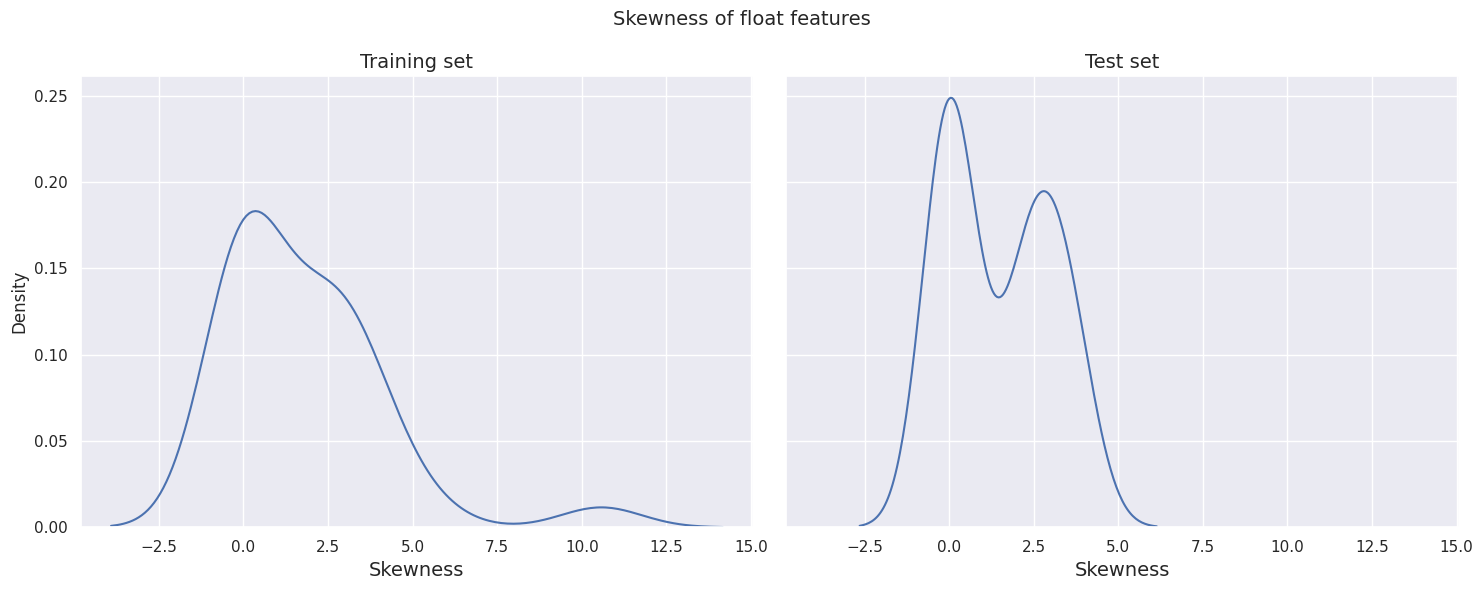

In [85]:
# Distribution of skewness of the float features in the training set and the test set
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharex = True, sharey = True)
sns.kdeplot(data = df_skew, x = 'Training set (all events)', ax = ax[0])
sns.kdeplot(data = df_skew, x = 'Test set (all events)', ax = ax[1])
ax[0].set_title("Training set", fontsize = 14)
ax[0].set_xlabel("Skewness", fontsize = 14)
ax[1].set_title("Test set", fontsize = 14)
ax[1].set_xlabel("Skewness", fontsize = 14)
plt.suptitle("Skewness of float features", fontsize = 14)
plt.tight_layout()
plt.show()

<Axes: >

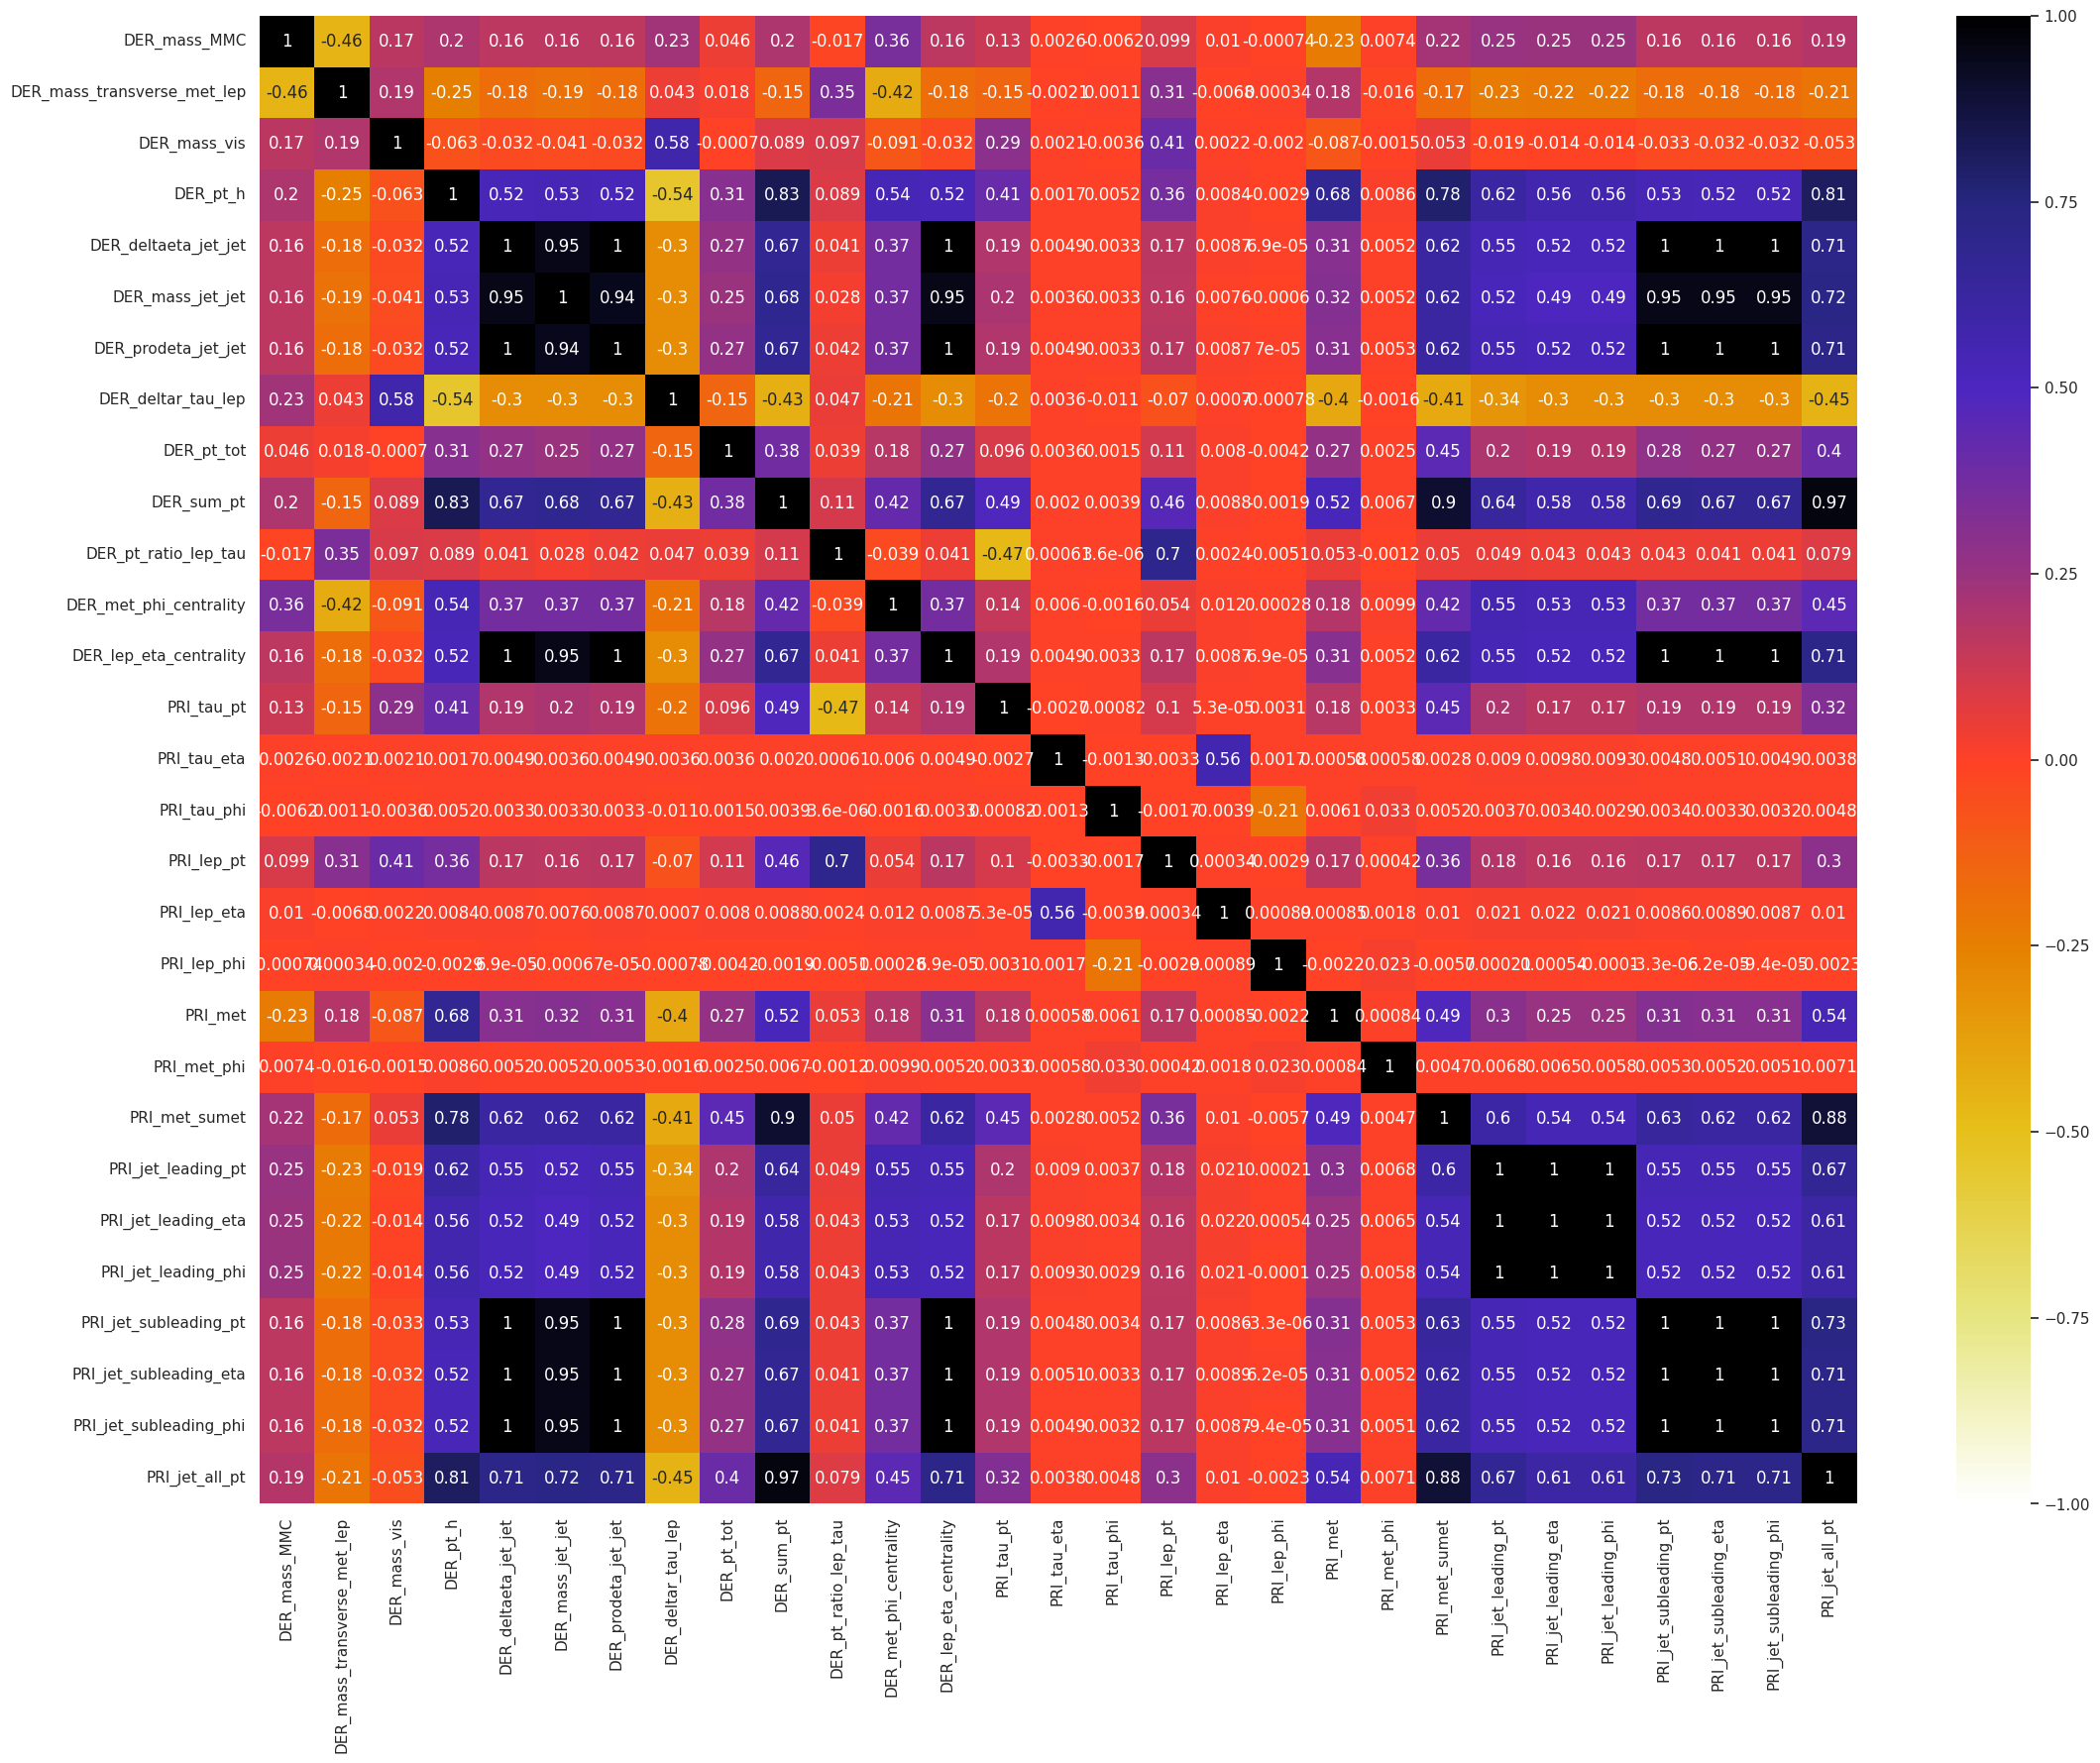

In [86]:
# Correlation heatmap of float features for the training set
plt.figure(figsize = (26, 19.5))
sns.heatmap(data_train[cols_float_test].corr(), vmin = -1, vmax = 1, annot = True, cmap = plt.cm.CMRmap_r)


<Axes: >

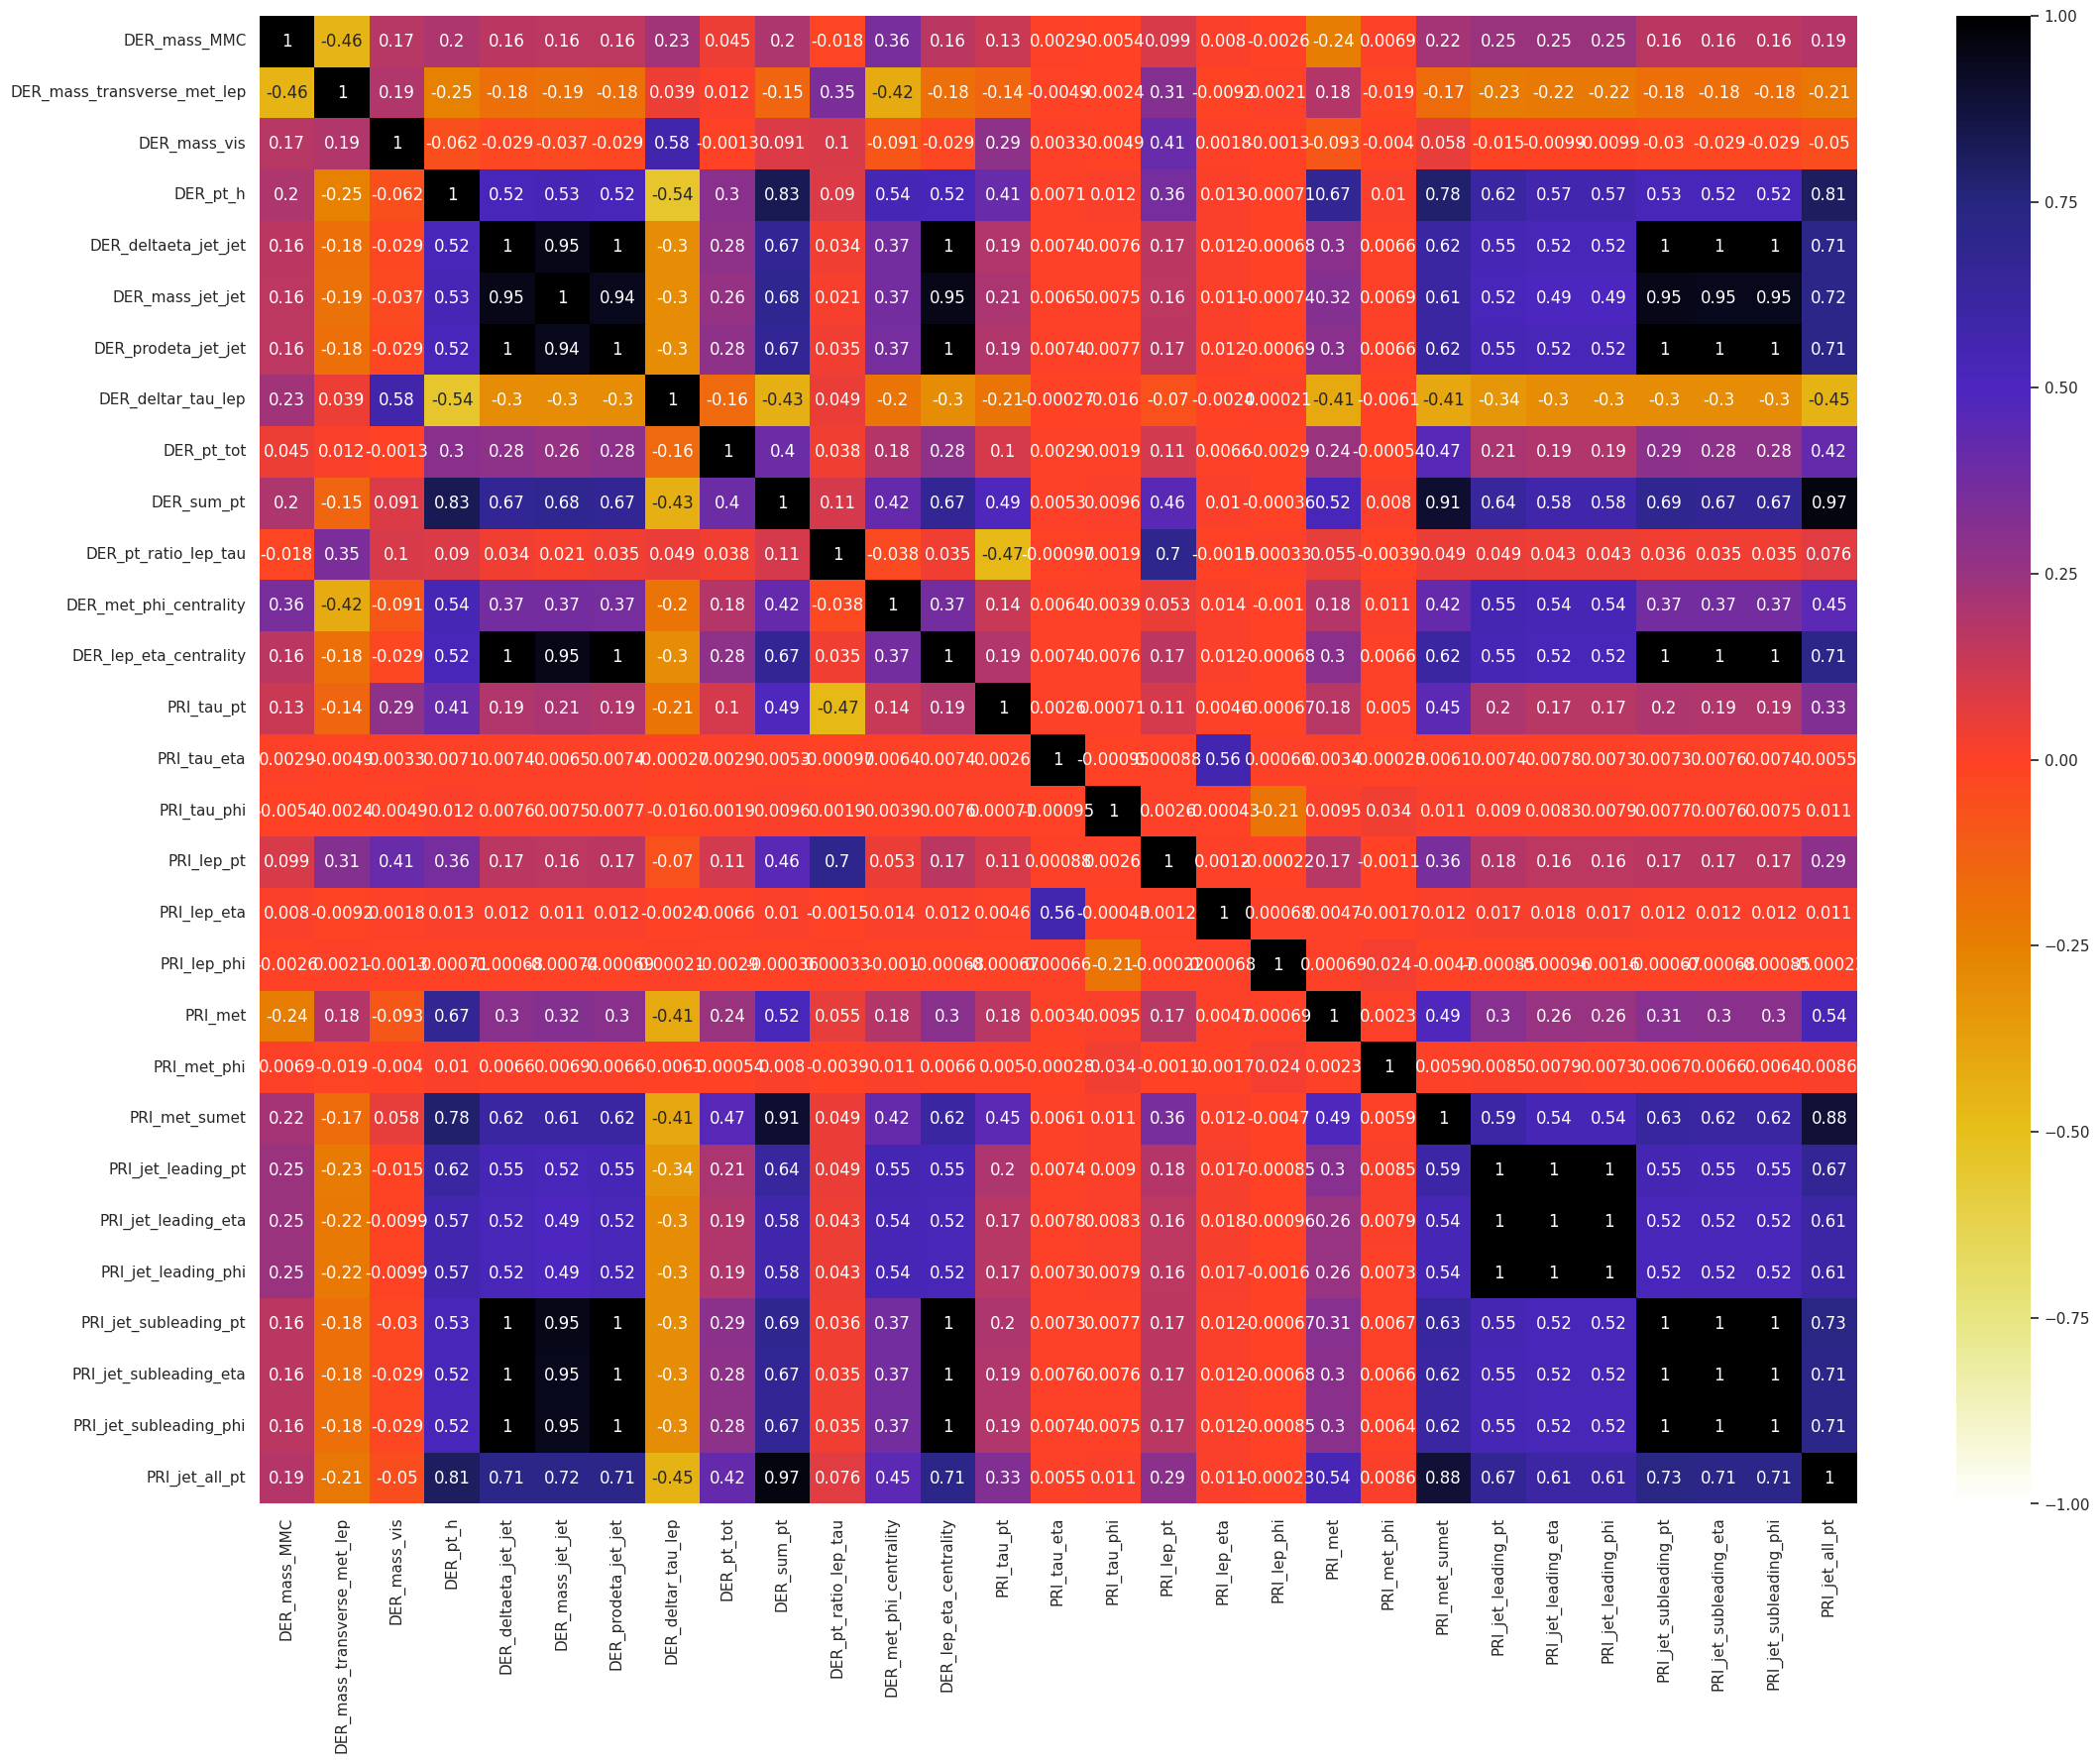

In [87]:
# Correlation heatmap of float features for the test set
plt.figure(figsize = (26, 19.5))
sns.heatmap(data_test[cols_float_test].corr(), vmin = -1, vmax = 1, annot = True, cmap = plt.cm.CMRmap_r)

In [88]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()


data_train['Label'] = enc.fit_transform(data_train['Label'])
data_train.head()


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,1
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,0
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,0
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,0
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,0


In [89]:
data_train.drop(['Weight'], axis=1,inplace=True)

In [90]:
data_train.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,1
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,0
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,0


In [91]:
data_train.shape,data_test.shape

((250000, 32), (550000, 31))

# Decision Tree

In [92]:
X = data_train.drop(columns = "Label")
y = data_train['Label']

In [93]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)


In [ ]:
# from sklearn.tree import DecisionTreeClassifier
# classifier_DT= DecisionTreeClassifier(criterion='gini', random_state=0)
# classifier_DT.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

[[40368  9046]
 [ 8577 17009]]


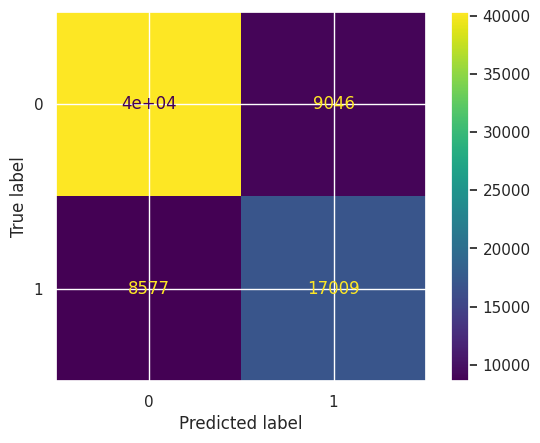

Accuracy : 0.7650266666666666
R2 score : -0.04541493006391062
Recall : 0.6647776127569764
Precision : 0.6528113605833813
F1 Score : 0.6587401483317519


In [94]:
from sklearn.tree import DecisionTreeClassifier
classifier_DT= DecisionTreeClassifier(criterion='gini', random_state=0)
classifier_DT.fit(X_train, y_train)

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
y_predict_dt = classifier_DT.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_predict_dt)
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=classifier_DT.classes_)
disp.plot()
plt.show()


from sklearn.metrics import accuracy_score,r2_score
print("Accuracy : "+ str(accuracy_score(y_test,y_predict_dt)))
print("R2 score : "+ str(r2_score(y_test,y_predict_dt)))
print("Recall : "+ str(recall_score(y_test,y_predict_dt)))
print("Precision : "+ str(precision_score(y_test,y_predict_dt)))
print("F1 Score : "+ str(f1_score(y_test,y_predict_dt)))




[[43215  6199]
 [ 9415 16171]]


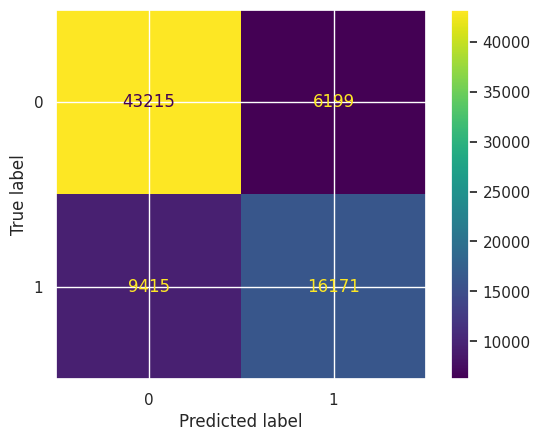

Accuracy : 0.7918133333333334
R2 score : 0.0737610669001929
Recall : 0.6320253263503478
Precision : 0.7228877961555655
F1 Score : 0.6744098757194095


In [95]:
from sklearn.tree import DecisionTreeClassifier
classifier_DT= DecisionTreeClassifier(criterion='gini',max_depth=4, random_state=0)
classifier_DT.fit(X_train, y_train)

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
y_predict_dt = classifier_DT.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_predict_dt)
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=classifier_DT.classes_)
disp.plot()
plt.show()


from sklearn.metrics import accuracy_score,r2_score
print("Accuracy : "+ str(accuracy_score(y_test,y_predict_dt)))
print("R2 score : "+ str(r2_score(y_test,y_predict_dt)))
print("Recall : "+ str(recall_score(y_test,y_predict_dt)))
print("Precision : "+ str(precision_score(y_test,y_predict_dt)))
print("F1 Score : "+ str(f1_score(y_test,y_predict_dt)))



[[43817  5597]
 [ 7819 17767]]


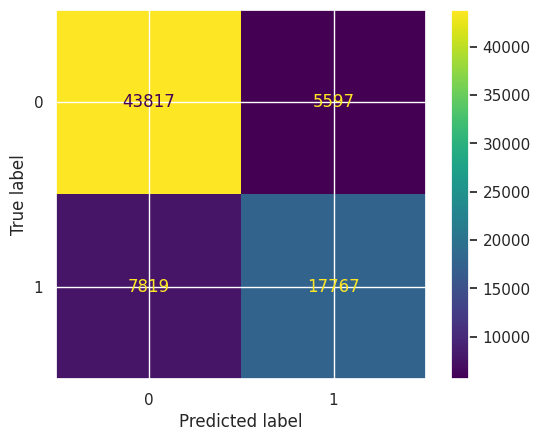

Accuracy : 0.82112
R2 score : 0.20414874302119812
Recall : 0.6944031892441179
Precision : 0.7604434172230783
F1 Score : 0.7259244126659857


In [96]:
from sklearn.tree import DecisionTreeClassifier
classifier_DT= DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_leaf=2, random_state=0)
classifier_DT.fit(X_train, y_train)

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
y_predict_dt = classifier_DT.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_predict_dt)
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=classifier_DT.classes_)
disp.plot()
plt.show()


from sklearn.metrics import accuracy_score,r2_score
print("Accuracy : "+ str(accuracy_score(y_test,y_predict_dt)))
print("R2 score : "+ str(r2_score(y_test,y_predict_dt)))
print("Recall : "+ str(recall_score(y_test,y_predict_dt)))
print("Precision : "+ str(precision_score(y_test,y_predict_dt)))
print("F1 Score : "+ str(f1_score(y_test,y_predict_dt)))



# ANN for the data

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense


In [ ]:
classifier = Sequential()
#add input layer and first hidden layer
classifier.add(Dense(6, kernel_initializer = "uniform", activation = "relu", input_dim = 31))
#add 2nd hidden layer
classifier.add(Dense(6, kernel_initializer = "uniform", activation = "relu"))

classifier.add(Dense(1, kernel_initializer = "uniform", activation = "sigmoid"))

classifier.compile(optimizer = "Adam", loss ="binary_crossentropy", metrics = ["accuracy"])


In [ ]:
classifier.fit(X_train, y_train, batch_size = 30, epochs = 10)

Epoch 1/10
5834/5834 [==============================] - 14s 2ms/step - loss: 0.4461 - accuracy: 0.7882
Epoch 2/10
5834/5834 [==============================] - 10s 2ms/step - loss: 0.4073 - accuracy: 0.8145
Epoch 3/10
5834/5834 [==============================] - 10s 2ms/step - loss: 0.4022 - accuracy: 0.8176
Epoch 4/10
5834/5834 [==============================] - 10s 2ms/step - loss: 0.4002 - accuracy: 0.8190
Epoch 5/10
5834/5834 [==============================] - 10s 2ms/step - loss: 0.3990 - accuracy: 0.8200
Epoch 6/10
5834/5834 [==============================] - 11s 2ms/step - loss: 0.3981 - accuracy: 0.8208
Epoch 7/10
5834/5834 [==============================] - 10s 2ms/step - loss: 0.3975 - accuracy: 0.8204
Epoch 8/10
5834/5834 [==============================] - 9s 2ms/step - loss: 0.3966 - accuracy: 0.8206
Epoch 9/10
5834/5834 [==============================] - 10s 2ms/step - loss: 0.3960 - accuracy: 0.8208
Epoch 10/10
5834/5834 [==============================] - 10s 2ms/step - lo

In [ ]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)


2344/2344 [==============================] - 4s 2ms/step


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)


In [ ]:
print(cm)

[[43525  5543]
 [ 7704 18228]]


# PyTorch

In [48]:
X = data_train.drop(columns = "Label")
y = data_train['Label']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Define the model class
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        # Define the layers
        self.fc1 = nn.Linear(31, 6)
        self.fc2 = nn.Linear(6, 6)
        self.fc3 = nn.Linear(6, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Create an instance of the model
classifier = Classifier()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters())

# Create an instance of StandardScaler
sc = StandardScaler()

# Convert the data to torch tensors and perform data preprocessing
X_train = torch.tensor(sc.fit_transform(X_train),dtype=torch.float32)
X_test = torch.tensor(sc.transform(X_test),dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(),dtype=torch.float32).reshape(-1,1)
y_test = torch.tensor(y_test.to_numpy(),dtype=torch.float32).reshape(-1,1)




num_epochs = 50
batch_size = 1000

# Train the model
for epoch in range(num_epochs):
  for i in range(0, len(X_train), batch_size):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = classifier(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
  print(f'Finished epoch {epoch}, latest loss {loss}')


Finished epoch 0, latest loss 0.5580180883407593
Finished epoch 1, latest loss 0.4491575062274933
Finished epoch 2, latest loss 0.40802499651908875
Finished epoch 3, latest loss 0.39470958709716797
Finished epoch 4, latest loss 0.38893982768058777
Finished epoch 5, latest loss 0.3865499198436737
Finished epoch 6, latest loss 0.38539862632751465
Finished epoch 7, latest loss 0.38480329513549805
Finished epoch 8, latest loss 0.3843393623828888
Finished epoch 9, latest loss 0.3839893639087677
Finished epoch 10, latest loss 0.3837110698223114
Finished epoch 11, latest loss 0.38348978757858276
Finished epoch 12, latest loss 0.3833119571208954
Finished epoch 13, latest loss 0.3831605315208435
Finished epoch 14, latest loss 0.3830387592315674
Finished epoch 15, latest loss 0.38292402029037476
Finished epoch 16, latest loss 0.3827708065509796
Finished epoch 17, latest loss 0.382534921169281
Finished epoch 18, latest loss 0.3823665976524353
Finished epoch 19, latest loss 0.38223037123680115
Fin

[[43945  5346]
 [ 7567 18142]]


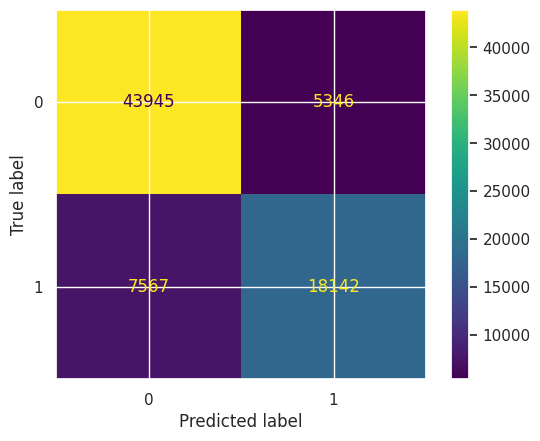

Accuracy : 0.8278266666666667
R2 score : 0.2357497234884035
Recall : 0.7056672760511883
Precision : 0.7723944141689373
F1 Score : 0.7375246458117364
Accuracy 0.8278266787528992


In [51]:
with torch.no_grad():
    y_pred = classifier(X_test)


y_predict_dt = y_pred.round()

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)


conf_matrix = confusion_matrix(y_test, y_predict_dt)
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=[0,1])
disp.plot()
plt.show()


from sklearn.metrics import accuracy_score,r2_score
print("Accuracy : "+ str(accuracy_score(y_test,y_predict_dt)))
print("R2 score : "+ str(r2_score(y_test,y_predict_dt)))
print("Recall : "+ str(recall_score(y_test,y_predict_dt)))
print("Precision : "+ str(precision_score(y_test,y_predict_dt)))
print("F1 Score : "+ str(f1_score(y_test,y_predict_dt)))

accuracy = (y_pred.round() == y_test).float().mean()
print(f"Accuracy {accuracy}")

In [97]:
X = data_train.drop(columns = "Label")
y = data_train['Label']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3)

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

# Define the model class
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        # Define the layers
        self.fc1 = nn.Linear(31, 6)
        self.fc2 = nn.Linear(6, 16)
        self.fc3 = nn.Linear(16, 6)
        self.fc4 = nn.Linear(6, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Create an instance of the model
classifier = Classifier()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters())

# Create an instance of StandardScaler
sc = StandardScaler()

# Convert the data to torch tensors and perform data preprocessing
X_train = torch.tensor(sc.fit_transform(X_train),dtype=torch.float32)
X_test = torch.tensor(sc.transform(X_test),dtype=torch.float32)
y_train = torch.tensor(y_train.to_numpy(),dtype=torch.float32).reshape(-1,1)
y_test = torch.tensor(y_test.to_numpy(),dtype=torch.float32).reshape(-1,1)




num_epochs = 50
batch_size = 1000

# Train the model
for epoch in range(num_epochs):
  for i in range(0, len(X_train), batch_size):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = classifier(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
  print(f'Finished epoch {epoch}, latest loss {loss}')


Finished epoch 0, latest loss 0.5153608918190002
Finished epoch 1, latest loss 0.42097651958465576
Finished epoch 2, latest loss 0.40376463532447815
Finished epoch 3, latest loss 0.3983146548271179
Finished epoch 4, latest loss 0.3954593241214752
Finished epoch 5, latest loss 0.3926112949848175
Finished epoch 6, latest loss 0.38969892263412476
Finished epoch 7, latest loss 0.3877737522125244
Finished epoch 8, latest loss 0.38677045702934265
Finished epoch 9, latest loss 0.386245459318161
Finished epoch 10, latest loss 0.3859153091907501
Finished epoch 11, latest loss 0.3856572210788727
Finished epoch 12, latest loss 0.3853728175163269
Finished epoch 13, latest loss 0.3850635290145874
Finished epoch 14, latest loss 0.38479071855545044
Finished epoch 15, latest loss 0.3845082223415375
Finished epoch 16, latest loss 0.3841867744922638
Finished epoch 17, latest loss 0.3835609257221222
Finished epoch 18, latest loss 0.38295483589172363
Finished epoch 19, latest loss 0.3822953701019287
Finis

[[43819  5360]
 [ 7603 18218]]


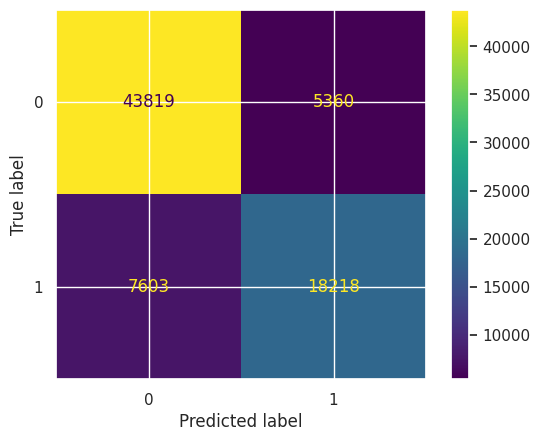

Accuracy : 0.82716
R2 score : 0.2343786618733663
Recall : 0.7055497463305062
Precision : 0.7726694376113326
F1 Score : 0.7375857810886859
Accuracy 0.8271600008010864


In [98]:
with torch.no_grad():
    y_pred = classifier(X_test)

y_predict_dt = y_pred.round()

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)


conf_matrix = confusion_matrix(y_test, y_predict_dt)
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=[0,1])
disp.plot()
plt.show()


from sklearn.metrics import accuracy_score,r2_score
print("Accuracy : "+ str(accuracy_score(y_test,y_predict_dt)))
print("R2 score : "+ str(r2_score(y_test,y_predict_dt)))
print("Recall : "+ str(recall_score(y_test,y_predict_dt)))
print("Precision : "+ str(precision_score(y_test,y_predict_dt)))
print("F1 Score : "+ str(f1_score(y_test,y_predict_dt)))

accuracy = (y_pred.round() == y_test).float().mean()
print(f"Accuracy {accuracy}")

#Semi Supervised Decision Tree

In [114]:
# Loading the training data labelled

data_train = pd.read_csv('higgs-boson/training.zip')
data_test = pd.read_csv('higgs-boson/test.zip')

print(pd.Series({"Memory usage": "{:.2f} MB".format(data_train.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data_train.shape)}).to_string())
data_train.head()


from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()


data_train['Label'] = enc.fit_transform(data_train['Label'])
data_train.drop(['Weight'], axis=1,inplace=True)
data_train.head()

Memory usage         62.94 MB
Dataset shape    (250000, 33)


,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,1
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,0
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,0


In [124]:
labelled_data = data_train.iloc[:5000]
unlabelled_data = data_train.iloc[5000:20000]

#data for final testing
final_test_data = data_train.iloc[20000:35000]



X = labelled_data.drop(columns = "Label")
y = labelled_data['Label']


X_test = unlabelled_data.drop(columns = "Label")
y_test = unlabelled_data['Label']


X_final_test = final_test_data.drop(columns = "Label")
y_final_test = final_test_data['Label']


Accuracy 0.6198666666666667
[[3924 5897]
 [2067 3112]]


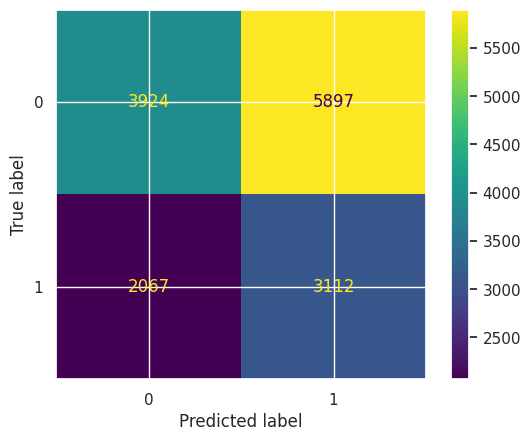

Accuracy : 0.4690666666666667
R2 score : -1.3486639855144884
Recall : 0.6008882023556671
Precision : 0.3454323454323454
F1 Score : 0.43868057513391595
Accuracy 0.6442666666666667
[[6887 2934]
 [3576 1603]]


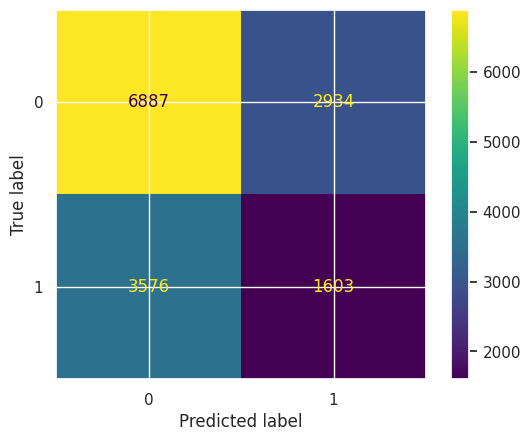

Accuracy : 0.566
R2 score : -0.9198647094047363
Recall : 0.309519212203128
Precision : 0.3533171699360811
F1 Score : 0.3299711815561959
Accuracy 0.6407333333333334
[[6932 2889]
 [3592 1587]]


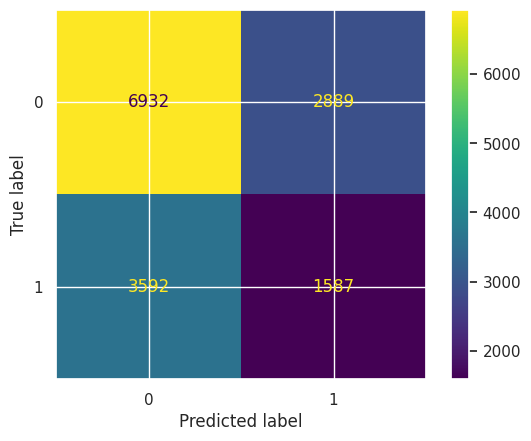

Accuracy : 0.5679333333333333
R2 score : -0.9113123166900301
Recall : 0.30642981270515546
Precision : 0.35455764075067026
F1 Score : 0.32874158467115483


In [125]:

import warnings
warnings.filterwarnings('ignore')

# from sklearn.tree import DecisionTreeClassifier
# classifier_DT= DecisionTreeClassifier(criterion='gini', random_state=0)
# classifier_DT.fit(X.values, y)

from sklearn.naive_bayes import GaussianNB
classifier_DT
for i in range(3):
  gnb = GaussianNB()

  # print(X)
  classifier_DT = gnb.fit(X.values, y)


  y_final_pred = classifier_DT.predict(X_final_test)
  accuracy = (y_final_pred.round() == y_final_test).mean()
  print(f"Accuracy {accuracy}")

  y_predict_dt = classifier_DT.predict(X_final_test).round()

  conf_matrix = confusion_matrix(y_test, y_predict_dt)
  print(conf_matrix)

  disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=[0,1])
  disp.plot()
  plt.show()


  from sklearn.metrics import accuracy_score,r2_score
  print("Accuracy : "+ str(accuracy_score(y_test,y_predict_dt)))
  print("R2 score : "+ str(r2_score(y_test,y_predict_dt)))
  print("Recall : "+ str(recall_score(y_test,y_predict_dt)))
  print("Precision : "+ str(precision_score(y_test,y_predict_dt)))
  print("F1 Score : "+ str(f1_score(y_test,y_predict_dt)))


  # y_predict_dt = classifier_DT.predict_proba(X_test)



  # Assuming you have an empty DataFrame with shape (1000, 31) called 'df_appended'
  pred = classifier_DT.predict_proba(X_test)

  df_appended = pd.DataFrame(columns=X_test.columns)
  df_appended_y = pd.Series([])


  # Iterate over the ndarray and check conditions
  indices_to_remove = []
  for index, values in enumerate(pred):
      # value1 =   # Access the first value
      # print(values[0])
      if values[0] > 0.8:
          df_appended = df_appended.append(X_test.iloc[index], ignore_index=True)
          # df_appended = pd.concat([df_appended, X_test.iloc[index]], ignore_index=True)
          # df_appended_y = df_appended_y.append(pd.Series({'Label': 0}), ignore_index=True)
          df_appended_y = pd.concat([df_appended_y, pd.Series({'Label': 0})], ignore_index=True)
          indices_to_remove.append(index)

      if values[1]>0.8:
          df_appended = df_appended.append(X_test.iloc[index], ignore_index=True)
          # df_appended = pd.concat([df_appended, X_test.iloc[index]], ignore_index=True)
          # df_appended_y = df_appended_y.append(pd.Series({'Label': 1}), ignore_index=True)
          df_appended_y = pd.concat([df_appended_y, pd.Series({'Label': 1})], ignore_index=True)

          indices_to_remove.append(index)

  # Remove the appended entries from the original DataFrame
  X_test = X_test.drop(X_test.index[indices_to_remove])
  # y = y.drop()

  # # Print the appended DataFrame
  # print(df_appended)
  # print(df_appended_y)

  # # Print the updated original DataFrame
  # print(X_test)

  concatenated_df = pd.concat([X, df_appended])
  concatenated_series = pd.concat([y, df_appended_y])

  X = concatenated_df
  # print(X)
  y = concatenated_series



  # print(concatenated_df)
  # print(concatenated_series)






[[6932 2889]
 [3592 1587]]


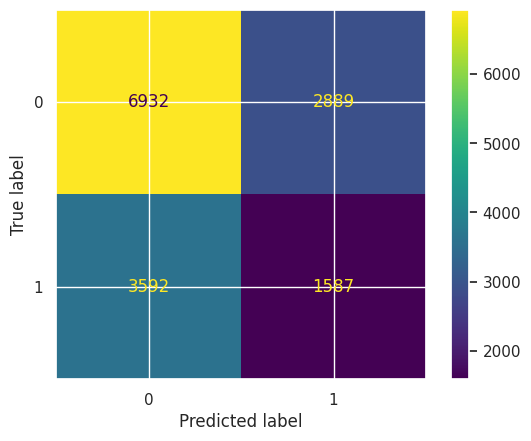

Accuracy : 0.5679333333333333
R2 score : -0.9113123166900301
Recall : 0.30642981270515546
Precision : 0.35455764075067026
F1 Score : 0.32874158467115483


In [111]:

y_predict_dt = classifier_DT.predict(X_final_test)



conf_matrix = confusion_matrix(y_test, y_predict_dt)
print(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=[0,1])
disp.plot()
plt.show()


from sklearn.metrics import accuracy_score,r2_score
print("Accuracy : "+ str(accuracy_score(y_test,y_predict_dt)))
print("R2 score : "+ str(r2_score(y_test,y_predict_dt)))
print("Recall : "+ str(recall_score(y_test,y_predict_dt)))
print("Precision : "+ str(precision_score(y_test,y_predict_dt)))
print("F1 Score : "+ str(f1_score(y_test,y_predict_dt)))
